<a href="https://colab.research.google.com/github/nabilbaugher/Google-Play-Store-Analysis/blob/master/Play_Store_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store Analysis: Random Forest
**Nabil Baugher and Manas Trivedi**

#Processing and Cleaning

### Initial imports and loading in the datafile:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/SaintAnford/Google-Play-Store-Analysis/master/googleplaystore.csv'
unclean = pd.read_csv(url)
unclean.head()

App  ...   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ...  4.0.3 and up
1                                Coloring book moana  ...  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ...  4.0.3 and up
3                              Sketch - Draw & Paint  ...    4.2 and up
4              Pixel Draw - Number Art Coloring Book  ...    4.4 and up

[5 rows x 13 columns]

In [ ]:
unclean.describe()

Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max      19.000000

In [ ]:
unclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


### First, row 10472's values were shifted left, so we corrected them. This left a hole in the data in the Category column so we looked up the category of the app on the Google Play Store and filled in the hole.  

In [ ]:
#Fixes the app that for some reason had a rating of 19.0/5.0 but results in 'NaN' for that row's category so I looked it up on the play store and it's lifestyle so I added that as well
unclean.iloc[10472,1:] = unclean.iloc[10472,1:].shift(1)
unclean.iloc[10472,1] = 'LIFESTYLE'

### We took a look at the Current Ver, Android Ver, and Size columns and discovered that they each contained 1000+ entries that said 'Varies with device', so we decided to remove the columns:

In [ ]:
unclean['Current Ver'].describe()

count                  10833
unique                  2831
top       Varies with device
freq                    1459
Name: Current Ver, dtype: object

In [ ]:
unclean[unclean['Android Ver'] == 'Varies with device'].size

17706

In [ ]:
unclean['Size'].describe()

count                  10841
unique                   461
top       Varies with device
freq                    1695
Name: Size, dtype: object

### Then we removed all of the duplicate apps in the data:

In [ ]:
#remove duplicate rows
print(unclean.shape)
unclean.drop_duplicates(inplace=True)
print(unclean.shape)

(10841, 13)
(10358, 13)


### In addition to Current Ver, Andriod Ver, and Size, we removed...
*   App: The app name did not offer any value to our investigation; it was basically just an irrelevant string of text.
*   Type: It showed whether the app was free or paid, but the Price column already contained the price of each app, so the Type column, which offered less information, was cut.
*   Genres: It essentially contained the same values as ‘Category’ but was more difficult to process.
*   Last Updated: It would need to be paired with the Current Ver category in order to give the complete picture. The date an app was last updated is irrelevant on its own because an app updated to version 1.0.1 yesterday would have the same value as an app updated to version 12.3.2 yesterday.

In [ ]:
#Remove unnecessary columns
#Type because the price column better captures that information
#The rest because they don't really make sense (feel free to edit this)
#That's cool thx --> I did a quick scan through of the full dataset on Kaggle and besides a few outliers, the Genre and Category section for every app were exactly the same. So I removed the Genres column just to make it easier for us if that's okay?
unclean = unclean.drop(['Current Ver','Android Ver','Size','App','Type','Genres','Last Updated'], axis=1)

In [ ]:
unclean.head()

Category Rating Reviews     Installs Price Content Rating
0  ART_AND_DESIGN    4.1     159      10,000+     0       Everyone
1  ART_AND_DESIGN    3.9     967     500,000+     0       Everyone
2  ART_AND_DESIGN    4.7   87510   5,000,000+     0       Everyone
3  ART_AND_DESIGN    4.5  215644  50,000,000+     0           Teen
4  ART_AND_DESIGN    4.3     967     100,000+     0       Everyone

### We then removed the extraneous characters from the Installs and Price columns and converted the remaining object columns to int and float:

In [ ]:
#Rremove the '+' at the end of each value in the Installs column
unclean['Installs'] = unclean['Installs'].apply(lambda x: x.replace('+',''))

In [ ]:
#removes the commas in the Installs column
unclean['Installs'] = unclean['Installs'].apply(lambda x: x.replace(',', ''))

In [ ]:
#removes the $ in the Price column
unclean['Price'] = unclean['Price'].apply(lambda x: x.replace('$', ''))

In [ ]:
unclean.dtypes

Category          object
Rating            object
Reviews           object
Installs          object
Price             object
Content Rating    object
dtype: object

In [ ]:
#Convert Rating, Installs, and Price to correct data types
unclean['Rating'] = unclean['Rating'].astype(float)
unclean['Installs'] = unclean['Installs'].astype(int)
unclean['Price'] = unclean['Price'].astype(float)
unclean['Reviews'] = unclean['Reviews'].astype(int)
unclean.dtypes

Category           object
Rating            float64
Reviews             int64
Installs            int64
Price             float64
Content Rating     object
dtype: object

### Let's take a look at what the data looks like now:

In [ ]:
unclean.head()

Category  Rating  Reviews  Installs  Price Content Rating
0  ART_AND_DESIGN     4.1      159     10000    0.0       Everyone
1  ART_AND_DESIGN     3.9      967    500000    0.0       Everyone
2  ART_AND_DESIGN     4.7    87510   5000000    0.0       Everyone
3  ART_AND_DESIGN     4.5   215644  50000000    0.0           Teen
4  ART_AND_DESIGN     4.3      967    100000    0.0       Everyone

### We then removed the rows with null values because we had plenty of data without them:

In [ ]:
unclean.shape

(10358, 6)

In [ ]:
unclean.dropna(0, inplace=True)
unclean.shape

(8893, 6)

## Time to convert all the data to int and float datatypes:

### We defined and used the transform() function to convert the Category and Content Rating columns to numerical form:

In [ ]:
def transform(x,col):
  index = 0
  for name in unclean[col].unique():
    if x == name:
      return index
    index += 1

In [ ]:
unclean['Category'] = unclean['Category'].apply(lambda x: transform(x, 'Category'))
unclean['Content Rating'] = unclean['Content Rating'].apply(lambda x: transform(x,'Content Rating'))

### Let's take a look at how the Installs column is categorized:

In [ ]:
print(pd.Series(np.sort(unclean['Installs'].unique())).apply(lambda x: str(x) + '+'))

0              1+
1              5+
2             10+
3             50+
4            100+
5            500+
6           1000+
7           5000+
8          10000+
9          50000+
10        100000+
11        500000+
12       1000000+
13       5000000+
14      10000000+
15      50000000+
16     100000000+
17     500000000+
18    1000000000+
dtype: object


## We decided to split the Installs column into three categories—low, average, and high. 
We decided to group the column because the intervals between the categories increased exponentially. We split it into three columns because we found that provided the best balance of specificity vs accuracy. Five categories, for example, when tested with all of the categorical algorithms, maxed out at 79% accuracy. Two categories resulted in a 95% accuracy, but the additional specificity of three categories was worth the 5% drop. 

In [ ]:
unclean.groupby('Installs').size()

Installs
1                3
5                9
10              69
50              56
100            303
500            199
1000           699
5000           426
10000          989
50000          462
100000        1110
500000         516
1000000       1486
5000000        683
10000000      1132
50000000       272
100000000      369
500000000       61
1000000000      49
dtype: int64

### We grouped the Installs column into the most even groups possible so as to avoid bias in the model:

In [ ]:
print(unclean[unclean['Installs'] <= 50000].size)
print(unclean[(unclean['Installs'] > 50000) & (unclean['Installs'] <= 1000000)].size)
print(unclean[unclean['Installs'] > 1000000].size)


19290
18672
15396


In [ ]:
install_key = pd.DataFrame({'Num Installs':['installs <= 50000','50000 < installs <= 1000000','installs > 1000000'],'Color':['Blue','Orange','Green']})
install_key

Num Installs   Color
0            installs <= 50000    Blue
1  50000 < installs <= 1000000  Orange
2           installs > 1000000   Green

This function was used to group the Installs column:

In [ ]:
#unclean['Installs'] = unclean['Installs'].apply(lambda x: 0 if x <= 100000 else 1)
def categorize_installs(num):
  if num <= 50000:
    return 0
  if num <= 1000000:
    return 1
  return 2
unclean['Installs'] = unclean['Installs'].apply(categorize_installs)

In [ ]:
unclean.head()

Category  Rating  Reviews  Installs  Price  Content Rating
0         0     4.1      159         0    0.0               0
1         0     3.9      967         1    0.0               0
2         0     4.7    87510         2    0.0               0
3         0     4.5   215644         2    0.0               1
4         0     4.3      967         1    0.0               0

### We took a final look at the datatypes to verify they were all numerical and that concluded the cleaning and processing of the data:

In [ ]:
unclean.dtypes

Category            int64
Rating            float64
Reviews             int64
Installs            int64
Price             float64
Content Rating      int64
dtype: object

In [ ]:
data = unclean

#Data Visualization

### Let's review the dataframe we created earlier to see what each color represents:

In [ ]:
install_key

Num Installs   Color
0            installs <= 50000    Blue
1  50000 < installs <= 1000000  Orange
2           installs > 1000000   Green

### First, we created a pairplot for an overview of the data:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


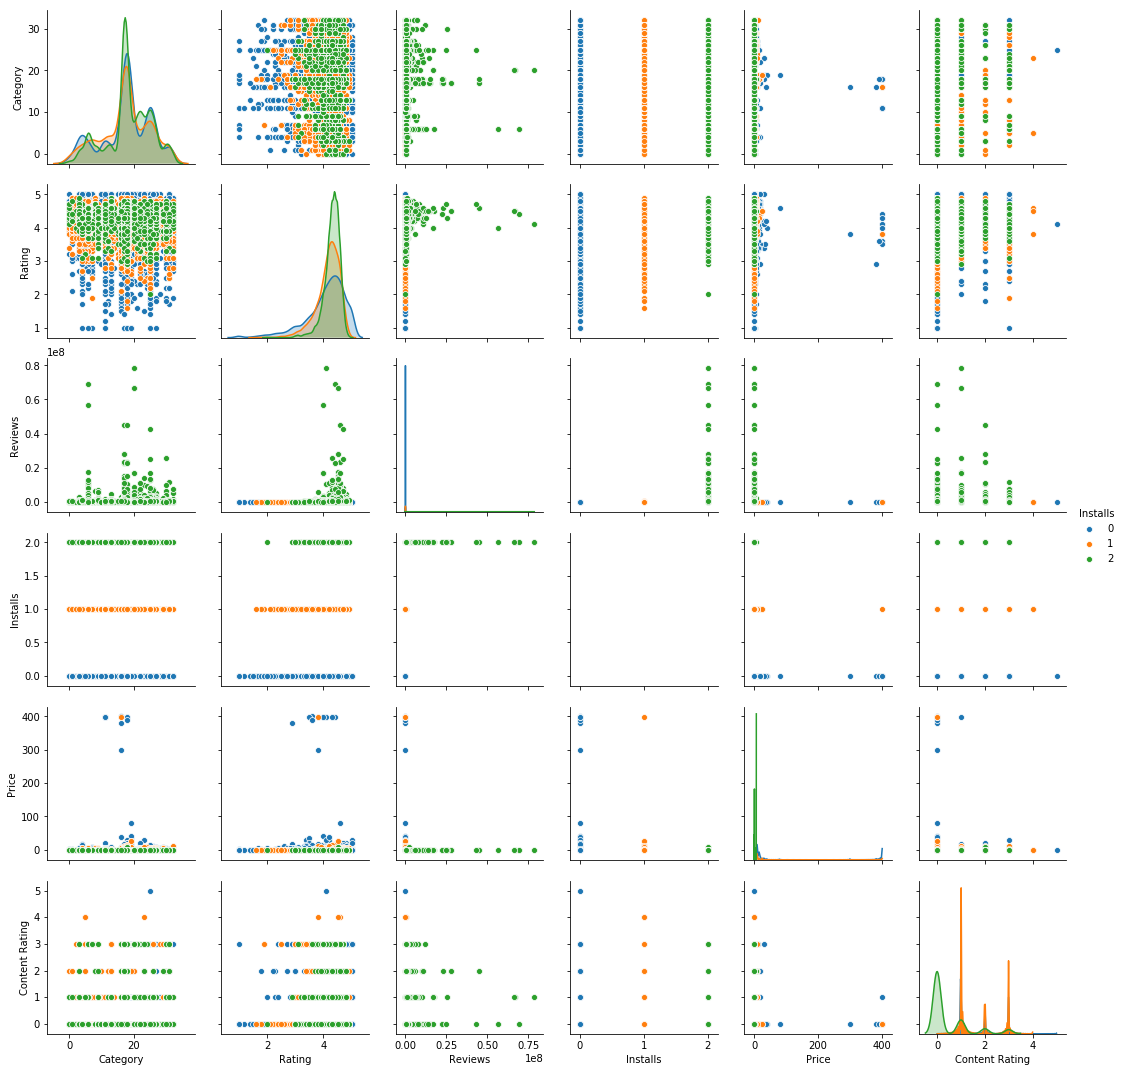

In [ ]:
sns.pairplot(data,hue='Installs')

### The Ratings kde looked interesting so we grouped the data by installs and took a closer look:
We found that the higher the number of installs, the more concentrated the reviews are around approximately 4.3. We hypothesized that, as an app gains popularity, there are naturally a higher number of reviews, and not everyone has the same taste, so the data naturally converges as the installs increase:

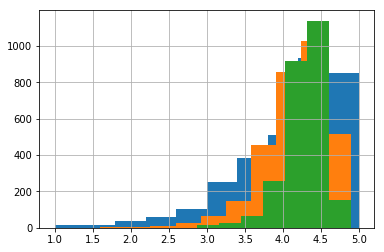

In [ ]:
low_installs = data.groupby('Installs').get_group(0)
med_installs = data.groupby('Installs').get_group(1)
high_installs = data.groupby('Installs').get_group(2)
low_installs['Rating'].hist()
med_installs['Rating'].hist()
high_installs['Rating'].hist()

In [ ]:
print(low_installs['Rating'].mean())
print(med_installs['Rating'].mean())
print(high_installs['Rating'].mean())

4.090816972767566
4.173536977491973
4.31111544461776


### This distplot shows the difference in distribution more clearly:

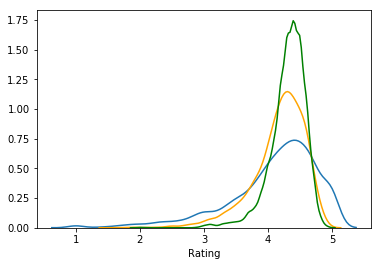

In [ ]:
fig, ax = plt.subplots()
sns.distplot(low_installs['Rating'], hist=False)
sns.distplot(med_installs['Rating'], color='orange', hist=False)
sns.distplot(high_installs['Rating'], color='g', hist=False)

### The following catplot verifies the correlation and confirms that as installs increase, the number of ratings increases:

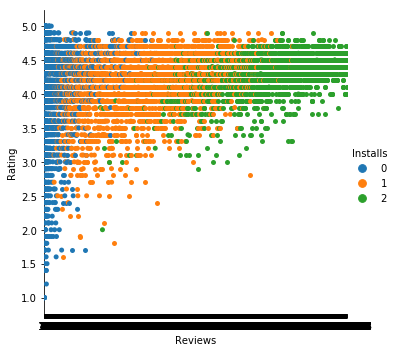

In [ ]:
#This cell takes 25+ minutes to run for some reason
sns.catplot(x="Reviews", y="Rating", hue="Installs", data=data)

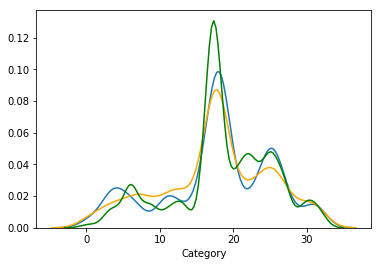

In [ ]:
#fig, ax = plt.subplots()
sns.distplot(low_installs['Category'], hist=False)
sns.distplot(med_installs['Category'], color='orange', hist=False)
sns.distplot(high_installs['Category'], color='g', hist=False)

### Then we took a look at the apps that cost money with the following pairplot:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


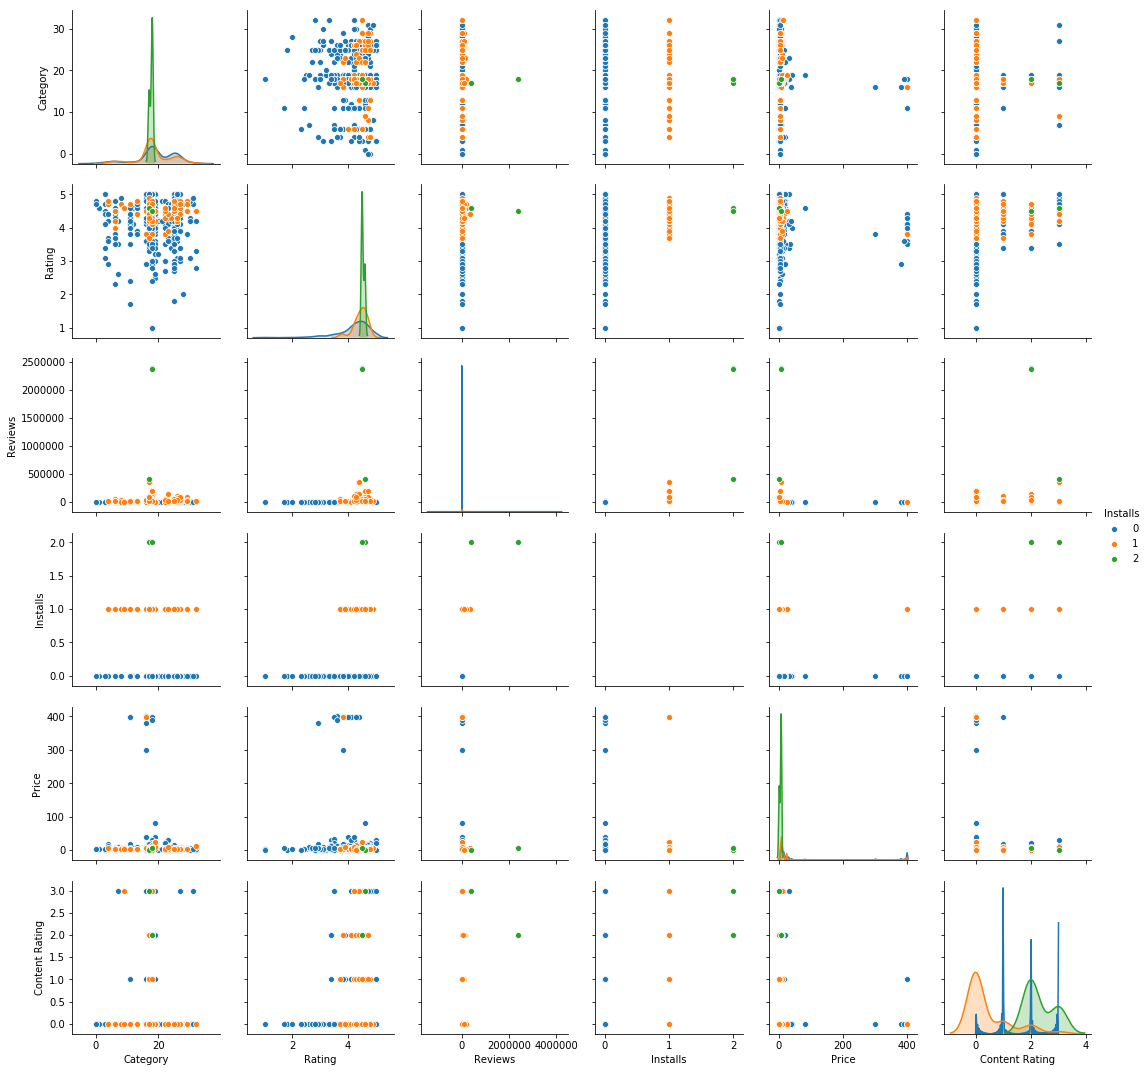

In [ ]:
sns.pairplot(data[data['Price'] > 0],hue='Installs')

### We took a closer look at the ratings because the kde plot looked like it revealed something interesting. 
We discovered that, while a similar distribution phenomenon emerged, there were virtually no data for high_installs.

Text(0.5, 0, 'Rating (out of 5)')

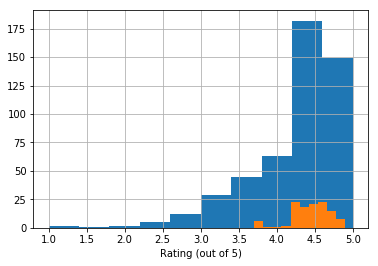

In [ ]:
low_installs[low_installs['Price'] > 0]['Rating'].hist()
med_installs[med_installs['Price'] > 0]['Rating'].hist()
high_installs[high_installs['Price'] > 0]['Rating'].hist()
plt.xlabel('Rating (out of 5)')

### We took a closer look at the mean of each category of installs, and found that higher installs correlated with a dramatically lower price:

In [ ]:
low_installs_price = round(low_installs['Price'].mean(),2)
med_installs_price = round(med_installs['Price'].mean(),2)
high_installs_price = round(high_installs['Price'].mean(),2)
print('Average price of apps with low installs: ${}'.format(low_installs_price))
print('Average price of apps with medium installs: ${}'.format(med_installs_price))
print('Average price of apps with high installs: ${}'.format(high_installs_price))
print('The average price of an app with low installs is {} times the average price of an app with high installs'.format(round(low_installs_price/high_installs_price)))

Average price of apps with low installs: $2.42
Average price of apps with medium installs: $0.29
Average price of apps with high installs: $0.01
The average price of an app with low installs is 242 times the average price of an app with high installs


#Support Vector Machine

### We decided a random forest model would probably be best, but we started with the other models to make sure. 
First, we implemented SVM with GridSearch and got decent results. 

In [ ]:
X = data.drop('Installs', axis=1)
y = data['Installs']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)

In [ ]:
from sklearn.svm import SVC
model = SVC()

In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,predictions))

[[436 179   0]
 [ 21 609   2]
 [  0 495  25]]


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       615
           1       0.47      0.96      0.64       632
           2       0.93      0.05      0.09       520

    accuracy                           0.61      1767
   macro avg       0.78      0.57      0.51      1767
weighted avg       0.77      0.61      0.54      1767



#Grid Search

In [ ]:
param_grid = {'C': [0.001,0.01,0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001,0.00001], 'kernel': ['rbf']} 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

In [ ]:
grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   1.2s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   1.2s
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ..................... C=0.001, gamma=1, kernel=rbf, total=   1.2s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=0.001, gamma=0.1, kernel=rbf, total=   1.3s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=0.001, gamma=0.1, kernel=rbf, total=   1.3s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=0.001, gamma=0.1, kernel=rbf, total=   1.3s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] .................. C=0.001, gamma=0.01, kernel=rbf, total=   1.3s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] .................. C=0.001, gamma=0.01, kernel=rbf, total=   1.3s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  3.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}

In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,grid_predictions))

[[552  63   0]
 [ 62 497  73]
 [  0  71 449]]


In [ ]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       615
           1       0.79      0.79      0.79       632
           2       0.86      0.86      0.86       520

    accuracy                           0.85      1767
   macro avg       0.85      0.85      0.85      1767
weighted avg       0.85      0.85      0.85      1767



#Logistic Regression

### Next, we implemented logistic regression. It performed very poorly because it is a very simple classification method. 

In [ ]:
X = data.drop('Installs', axis=1)
y = data['Installs']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,log_predictions))

[[ 67 548   0]
 [  0 382 250]
 [  0  16 504]]


In [ ]:
print(classification_report(y_test,log_predictions))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20       615
           1       0.40      0.60      0.48       632
           2       0.67      0.97      0.79       520

    accuracy                           0.54      1767
   macro avg       0.69      0.56      0.49      1767
weighted avg       0.69      0.54      0.47      1767



#KNN

### Next, we implemented KNN, which performed about as well as the SVM. 

In [ ]:
X = data.drop('Installs', axis=1)
y = data['Installs']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 0)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
scaled_features = scaler.transform(X)

In [ ]:
scaled = pd.DataFrame(scaled_features,columns=data.columns[:-1])
scaled.head()

Category    Rating   Reviews  Installs     Price
0 -2.444662 -0.160980 -0.163254 -0.059654 -0.440502
1 -2.444662 -0.544724 -0.162977 -0.059654 -0.440502
2 -2.444662  0.990253 -0.133283 -0.059654 -0.440502
3 -2.444662  0.606508 -0.089318 -0.059654  0.860239
4 -2.444662  0.222764 -0.162977 -0.059654 -0.440502

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
predictions = knn.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,predictions))

[[542  73   0]
 [ 83 463  86]
 [  0  89 431]]


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       615
           1       0.74      0.73      0.74       632
           2       0.83      0.83      0.83       520

    accuracy                           0.81      1767
   macro avg       0.81      0.81      0.81      1767
weighted avg       0.81      0.81      0.81      1767



In [ ]:
error_rates = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error_rates.append(np.mean(pred != y_test))

Text(0, 0.5, 'Error Rate')

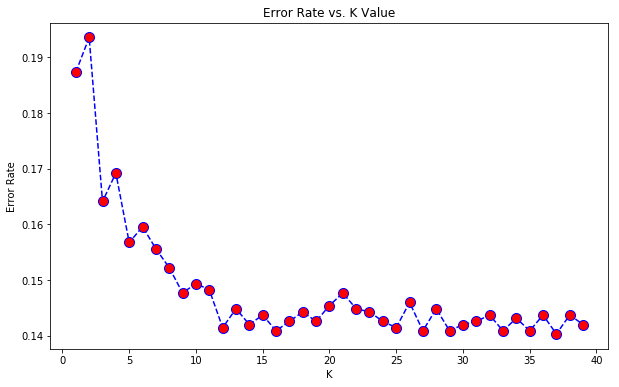

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rates,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
knn_v2 = KNeighborsClassifier(n_neighbors=29)

In [ ]:
knn_v2.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')

In [ ]:
v2_predictions = knn_v2.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,v2_predictions))

[[554  61   0]
 [ 56 523  53]
 [  0  79 441]]


In [ ]:
print(classification_report(y_test,v2_predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       615
           1       0.79      0.83      0.81       632
           2       0.89      0.85      0.87       520

    accuracy                           0.86      1767
   macro avg       0.86      0.86      0.86      1767
weighted avg       0.86      0.86      0.86      1767



#Decision Trees
We thought a Decision Tree/Random Forest Model would be the most effective because of it's versatile and works well even with data that contains a lot of outliers and it handles non-linear data well. After trying all of the models, we verified that the random forest worked the best. 

In [ ]:
X = data.drop('Installs',axis=1)
y = data['Installs']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=10)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()

In [ ]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
t_predictions = tree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(confusion_matrix(y_test,t_predictions))

[[553  64   0]
 [ 60 505  84]
 [  0  65 448]]


In [ ]:
print(classification_report(y_test,t_predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       617
           1       0.80      0.78      0.79       649
           2       0.84      0.87      0.86       513

    accuracy                           0.85      1779
   macro avg       0.85      0.85      0.85      1779
weighted avg       0.85      0.85      0.85      1779



### Let's take a look at the decision tree: 
Because it is so large, there was likely to be ovefitting, so we decided to use a random forest model to mitigate that. 

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.674149 to fit



In [ ]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(n_estimators=200)
random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
random_pred = random.predict(X_test)

### Evaluation
The model performed better with a 90% f1-score!

In [ ]:
print(confusion_matrix(y_test,random_pred))

[[576  41   0]
 [ 41 555  53]
 [  0  59 454]]


In [ ]:
print(classification_report(y_test,random_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       617
           1       0.85      0.86      0.85       649
           2       0.90      0.88      0.89       513

    accuracy                           0.89      1779
   macro avg       0.89      0.89      0.89      1779
weighted avg       0.89      0.89      0.89      1779

